# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA)
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [20]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

# for i in range(1,41):
#     for j in range(1,11):
#         imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
#         img = cv2.imread(imgPath, -1)

#         allFaces.append(img)
#         labels.append(i)

# Define the path to the dataset
base_path = "/content/drive/My Drive/rollnumber_A2/rollnumber_A2_Q3"

# Initialize lists to store images and labels
allFaces = []
labels = []

# Loop through the directories and files to load images and labels
for i in range(1, 41):
    for j in range(1, 11):
        imgPath = os.path.join(base_path, "ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        if img is not None:
            allFaces.append(img)
            labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [21]:
def principalComponentAnalysis(trainFaces, numComponents):
    """
    Perform Principal Component Analysis (PCA) on the training faces.

    Args:
    - trainFaces: numpy array of shape (num_images, image_height, image_width) representing the training faces
    - numComponents: number of principal components to retain

    Returns:
    - eigenFaces: numpy array of shape (image_height * image_width, numComponents) representing the eigenfaces
    """
    # Flatten the trainFaces array
    num_images = trainFaces.shape[0]
    X = trainFaces.reshape(num_images, -1)  # Flatten each image

    # Mean center the data
    meanFace = np.mean(X, axis=0)
    X_centered = X - meanFace

    # Compute the covariance matrix
    cov_matrix = np.cov(X_centered.T)

    # Eigen decomposition
    eigenvalues, eigenFaces = np.linalg.eig(cov_matrix)

    # Sort eigenvectors by descending eigenvalues
    idx = np.argsort(-eigenvalues)
    eigenFaces = eigenFaces[:, idx]
    eigenvalues = eigenvalues[idx]

    # Select the top 'numComponents' eigenvectors
    eigenFaces = eigenFaces[:, :numComponents]

    # Normalize Eigenfaces
    eigenFaces = eigenFaces / np.linalg.norm(eigenFaces, axis=0)

    return eigenFaces


In [22]:
# Perform PCA
eigenFaces = principalComponentAnalysis(trainFaces, numComponents=20)

In [ ]:
import os
print(os.path.abspath("Q2.ipybn"))

E:\Ayush\rollnumber_A2\rollnumber_A2\rollnumber_A2_Q3\Q2.ipybn


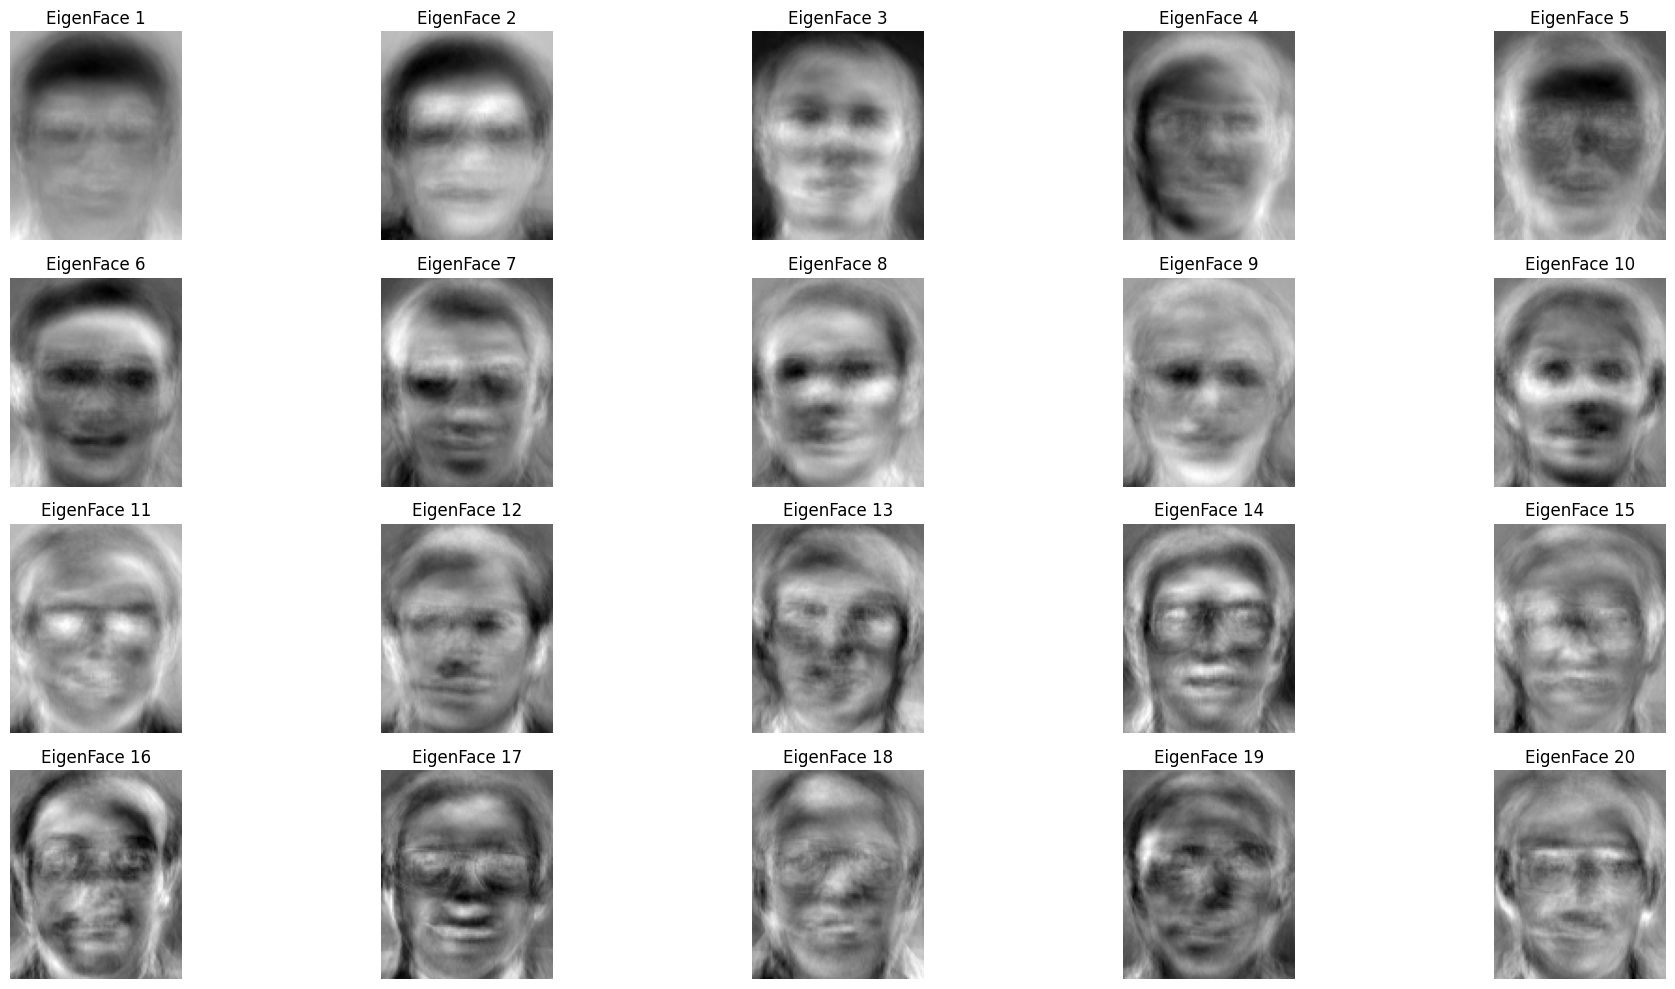

In [ ]:

# Define plot function
num_cols = 5
num_faces = eigenFaces.shape[1]
num_rows = (num_faces + num_cols - 1) // num_cols

# Increase the figure size
plt.figure(figsize=(20, 10))

for i in range(num_faces):
    plt.subplot(num_rows, num_cols, i + 1)
    eigenface = eigenFaces[:, i].real  # Take the real part
    plt.imshow(eigenface.reshape(112, 92), cmap='gray')  # Use eigenface instead of eigenFaces[:, i]
    plt.title(f'EigenFace {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


#### Implement Image Reconstruction from Eigenfaces


In [26]:
# Compute mean face
meanFace = np.mean(trainFaces.reshape(trainFaces.shape[0], -1), axis=0)

Explain your steps with comments and write a brief explanation of the method.

C:\Users\suraj\AppData\Local\Temp\ipykernel_36640\220422090.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  reconstructedFace = np.clip(reconstructedFace, 0, 255).astype(np.uint8)


IndexError: index 4 is out of bounds for axis 0 with size 4

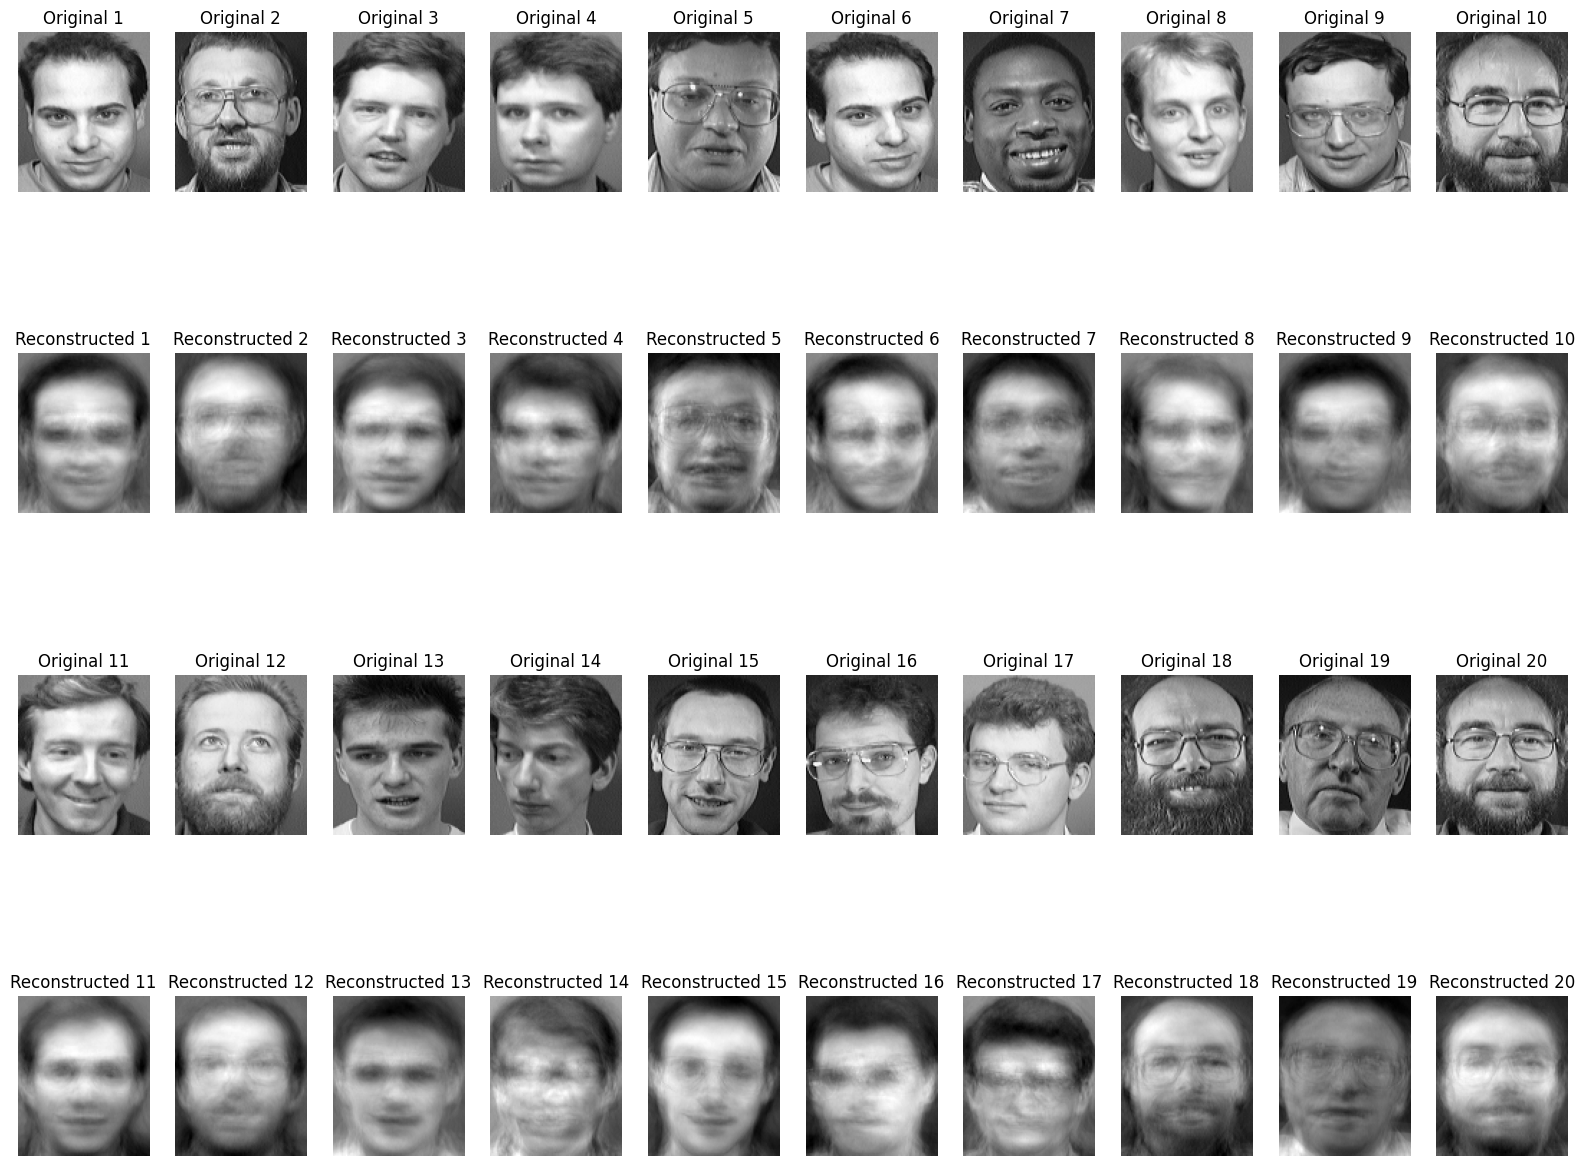

In [ ]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Reconstructs an image from its eigenface representation.

    Args:
    - testFace: numpy array representing the test face to be reconstructed
    - eigenFaces: numpy array of shape (image_height * image_width, num_components) representing the eigenfaces
    - meanFace: numpy array representing the mean face

    Returns:
    - reconstructedFace: numpy array representing the reconstructed face
    """
    # Mean subtraction
    meanFace_reshaped = meanFace.reshape(testFace.shape)  # Reshape meanFace to match testFace
    testFace_centered = testFace - meanFace_reshaped

    # Projection onto Eigenspace
    weights = np.dot(testFace_centered.flatten(), eigenFaces)

    # Reconstruction
#     reconstructedFace = meanFace_reshaped + np.dot(weights, eigenFaces.T)
    # Reconstruction
    reconstructedFace = meanFace_reshaped.flatten() + np.dot(weights, eigenFaces.T)


    # Normalization
    reconstructedFace = np.clip(reconstructedFace, 0, 255).astype(np.uint8)

    return reconstructedFace


# Plot reconstructions
numTestFaces = testFaces.shape[0]
fig, axes = plt.subplots(4, 10, figsize=(20, 16))

for i in range(numTestFaces):
    test_face = testFaces[i]
    reconstructed_face = imageReconstruction(test_face, eigenFaces, meanFace)

    # Plot original test face
    row = i // 10 * 2
    col = i % 10
    axes[row, col].imshow(test_face, cmap='gray')
    axes[row, col].set_title(f'Original {i+1}')
    axes[row, col].axis('off')

    # Plot reconstructed face
    axes[row + 1, col].imshow(reconstructed_face.reshape(test_face.shape), cmap='gray')  # Reshape reconstructed_face
    axes[row + 1, col].set_title(f'Reconstructed {i+1}')
    axes[row + 1, col].axis('off')

# Hide empty subplots
for i in range(numTestFaces, 10 * 4):
    axes[i // 10 * 2, i % 10].axis('off')
    axes[i // 10 * 2 + 1, i % 10].axis('off')

# Add spacing between rows
plt.subplots_adjust(hspace=0.5)

plt.show()








#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

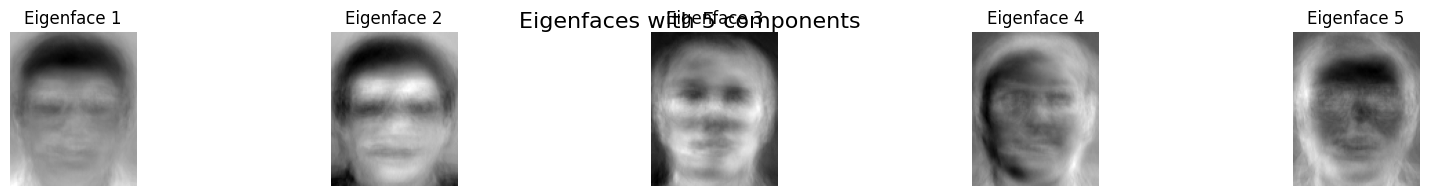

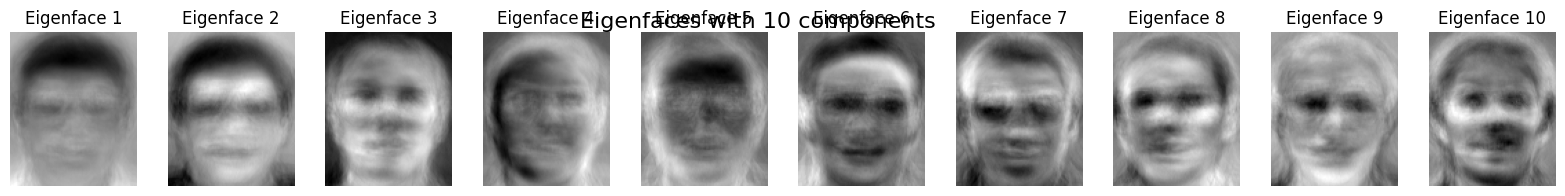

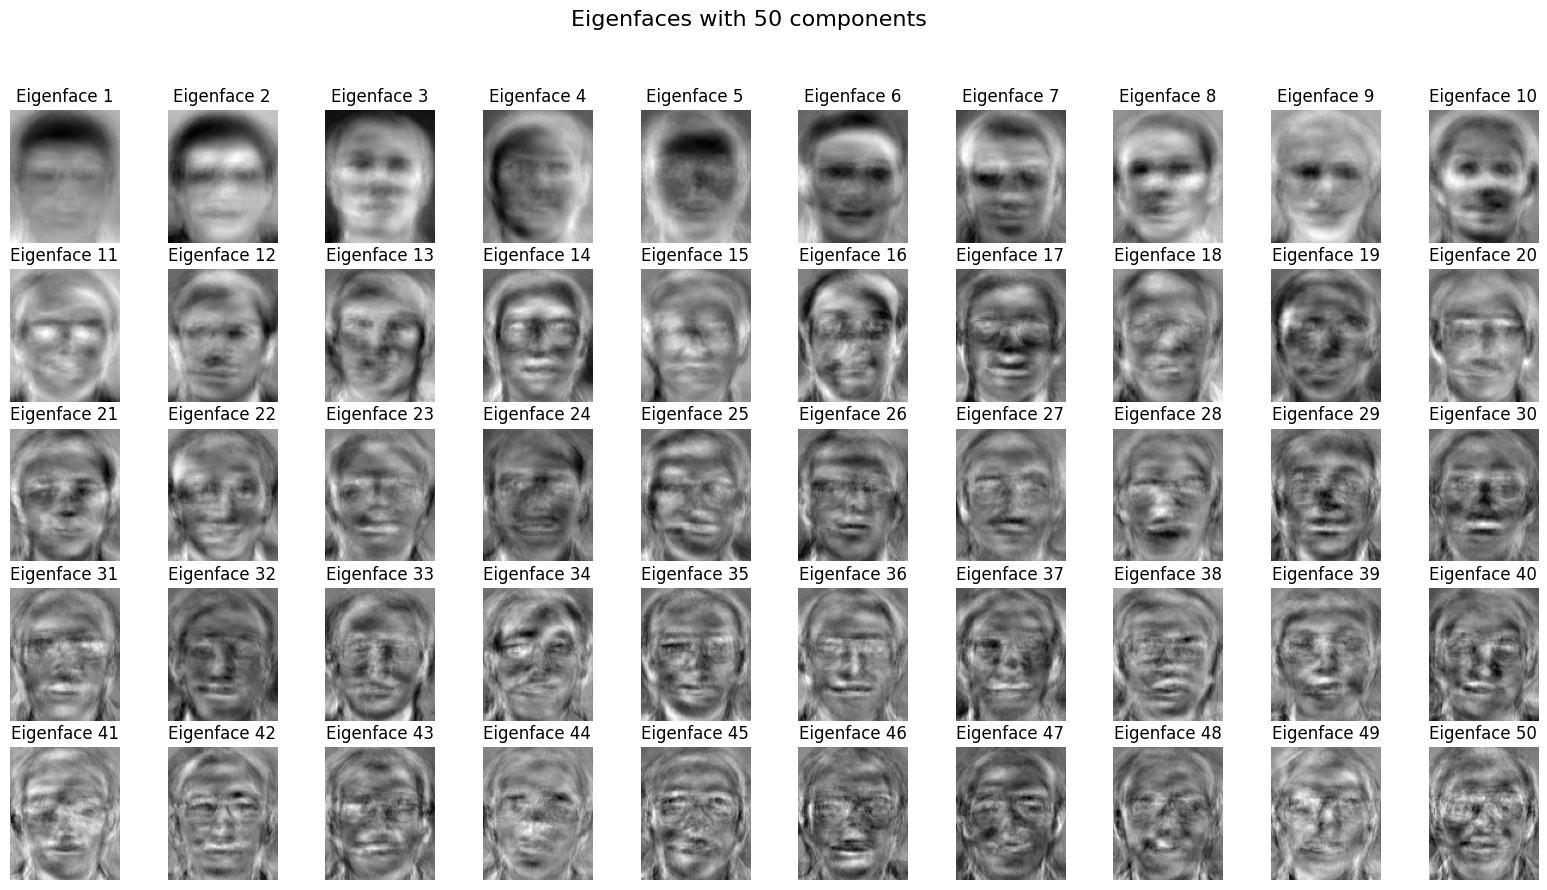

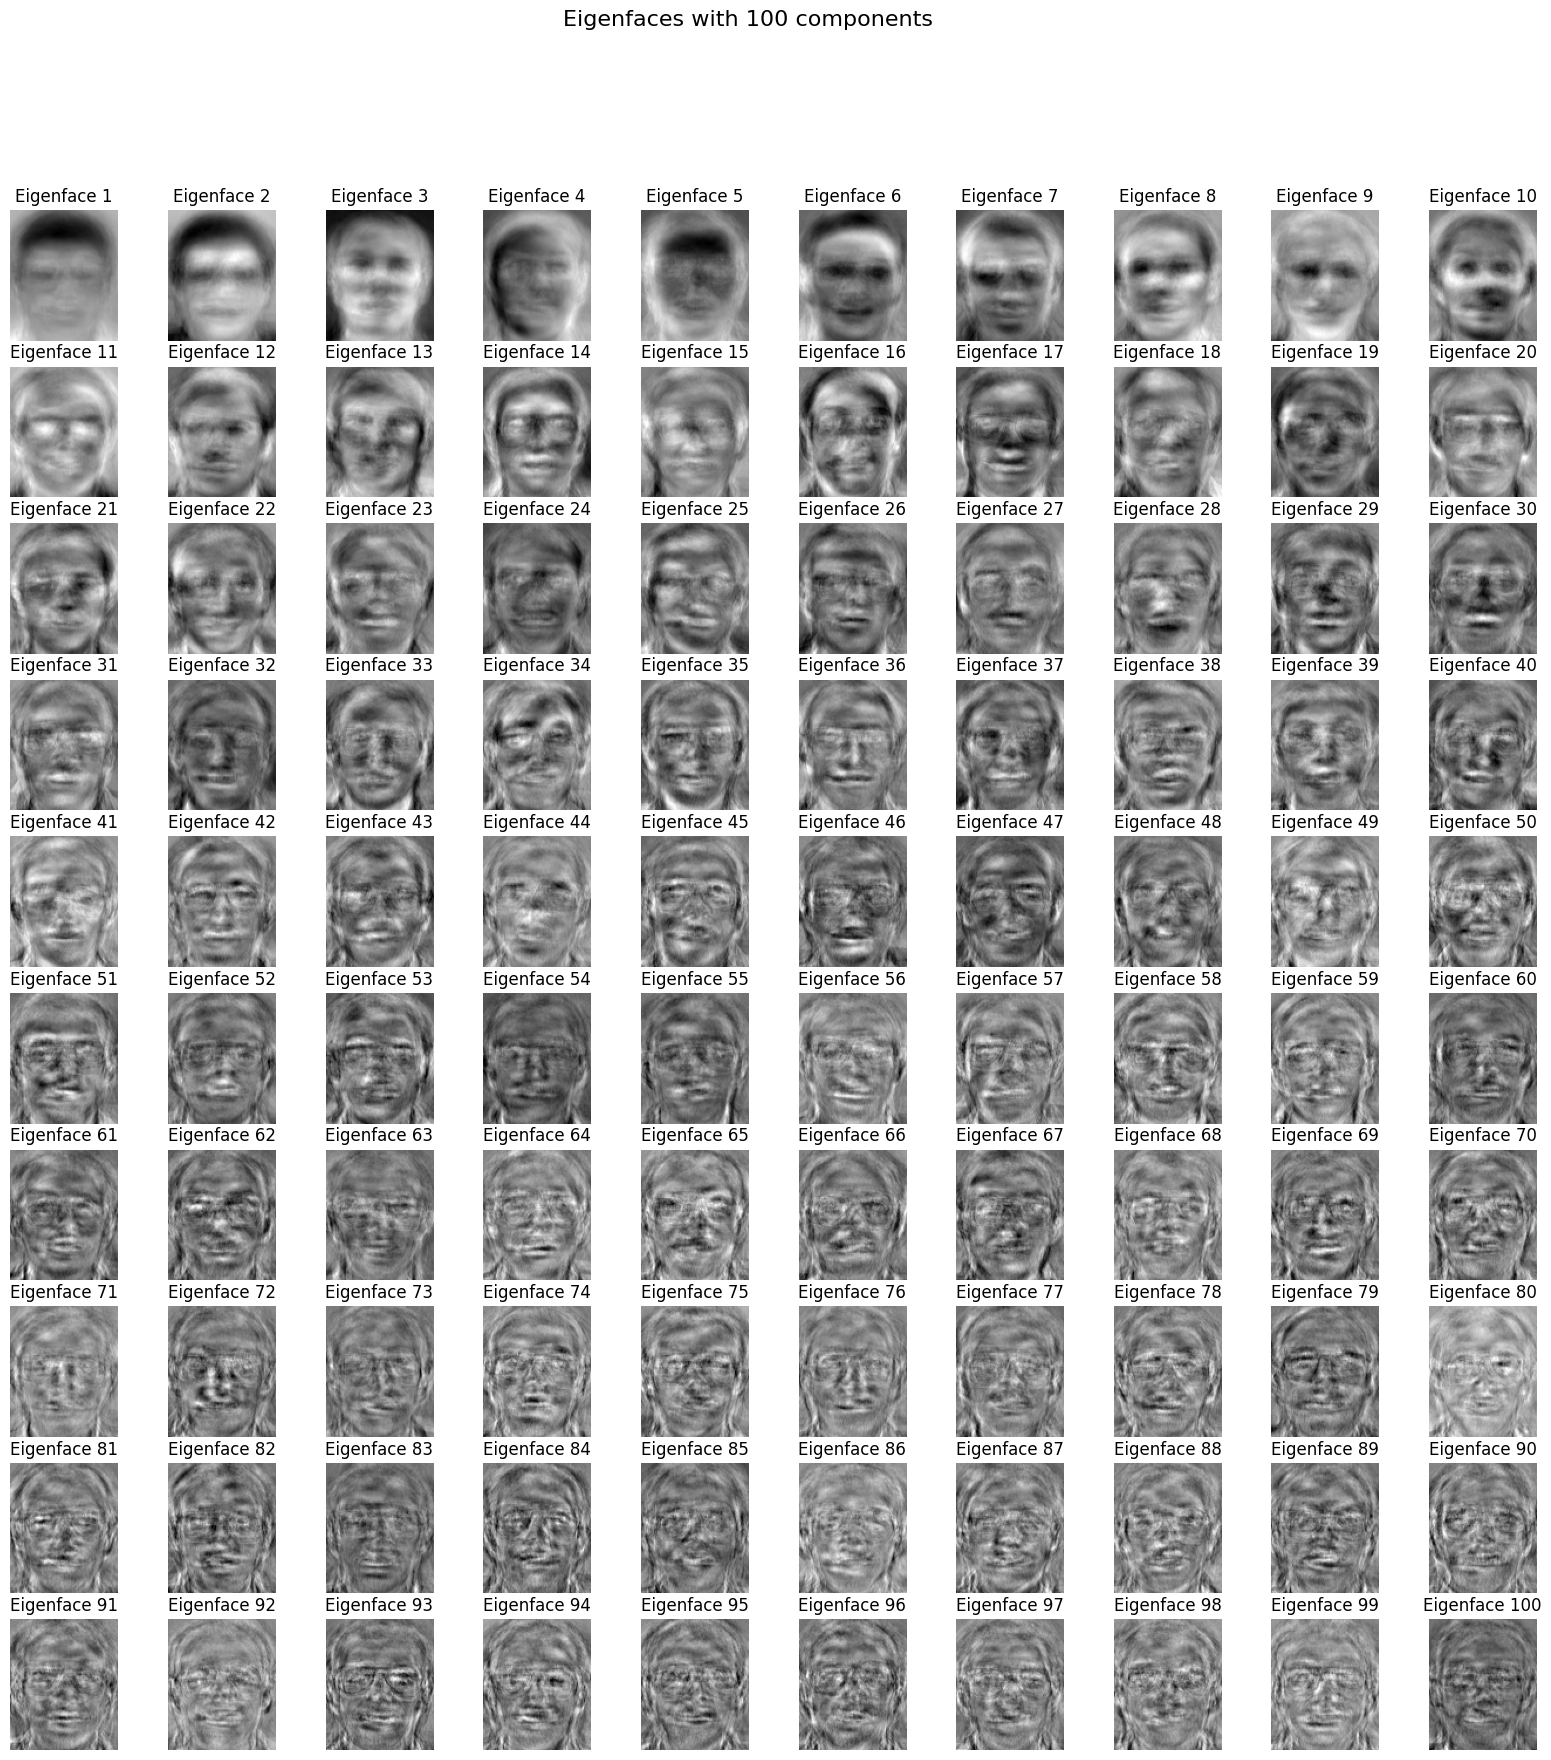

In [ ]:
%matplotlib inline

def displayNfactors(trainFaces, numComponentsList):
    """
    Visualize the results for different numbers of factors (principal components).

    Args:
    - trainFaces: numpy array of shape (num_images, image_height, image_width) representing the training faces
    - numComponentsList: list of integers representing the number of principal components to use

    Returns:
    - None
    """
    for numComponents in numComponentsList:
        # Perform PCA
        eigenFaces = principalComponentAnalysis(trainFaces, numComponents=numComponents)

        # Plot the eigenfaces with appropriate labels
        numEigenFaces = eigenFaces.shape[1]
        numColumns = min(numEigenFaces, 10)  # Display up to 10 eigenfaces per row
        numRows = (numEigenFaces + numColumns - 1) // numColumns
        fig, axes = plt.subplots(numRows, numColumns, figsize=(20, 2 * numRows))

        # Reshape axes array if there's only one row or one column
        if numRows == 1:
            axes = axes[np.newaxis, :]
        if numColumns == 1:
            axes = axes[:, np.newaxis]

        for i in range(numEigenFaces):
            row = i // numColumns
            col = i % numColumns
            eigenface = eigenFaces[:, i].real  # Take the real part
            axes[row, col].imshow(eigenface.reshape(112, 92), cmap='gray')
            axes[row, col].set_title(f'Eigenface {i+1}')
            axes[row, col].axis('off')

        plt.suptitle(f'Eigenfaces with {numComponents} components', fontsize=16)
        plt.show()

# Define the list of numbers of principal components
numComponentsList = [5, 10, 50, 100]

# Call the function to visualize the results
displayNfactors(trainFaces, numComponentsList)


#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [23]:
# Calculate the mean eigenface
meanEigenFace = np.mean(trainFaces, axis=0).flatten()

Iterate through all the images in the test data and test the accuracy by taking different number of components

Plot Number of eigenvectors vs Mean Square Error

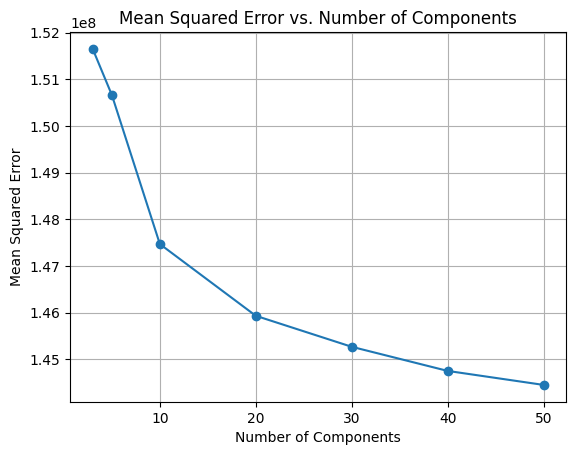

Plot Number of eigenvectors vs Logarithmic Mean Square Error

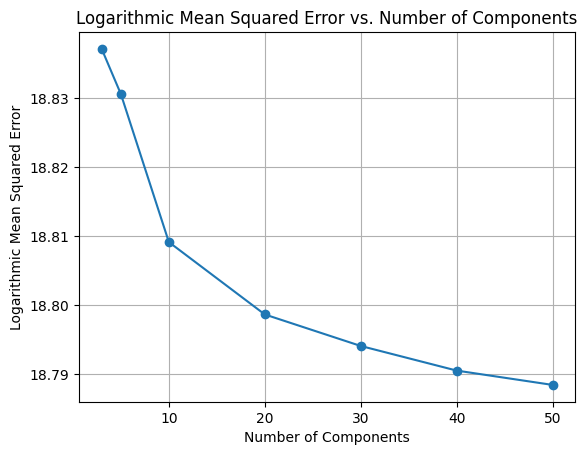

In [ ]:
    # Plot Logarithmic MSE vs. number of components
    plt.plot(components, np.log(mse), marker='o', label='Logarithmic Mean Squared Error')
    plt.title('Logarithmic Mean Squared Error vs. Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Logarithmic Mean Squared Error')
    plt.grid(True)
    plt.show()

In [27]:
def getClass(test_image, eigenfaces, meanFace, X_train, y_train):
    """
    Classifies a face image based on PCA projections and reconstruction error.

    Args:
        test_image: The test image for which the class needs to be predicted.
        eigenfaces: Eigenvectors obtained from PCA.
        meanFace: Mean eigenface obtained from PCA.
        X_train: Training set of images.
        y_train: Labels corresponding to the training images.

    Returns:
        closest_image: Image with the smallest reconstruction error.
        error_value: Smallest reconstruction error.
        prediction_class: Predicted class (person).
    """
    # Reshape meanFace for compatibility
    meanFace = meanFace.flatten()

    # Project the test image
    test_weights = np.dot(eigenfaces.T, test_image.flatten() - meanFace)

    min_error = float('inf')  # Initialize with a large error
    closest_image = None
    predicted_class = None

    # Compare with projected training images
    for train_image, train_label in zip(X_train, y_train):
        train_weights = np.dot(eigenfaces.T, train_image.flatten() - meanFace)

        # Calculate error (could be L2-norm or reconstruction based)
        error = np.linalg.norm(test_weights - train_weights)  # Example: L2-norm

        # Optionally reconstruct and calculate error
        # reconstructed_image = imageReconstruction(test_image, eigenfaces, meanFace)
        # error = np.mean((test_image - reconstructed_image) ** 2)

        if error < min_error:
            min_error = error
            closest_image = train_image
            predicted_class = train_label

    return closest_image, min_error, predicted_class


In [28]:
# Initialize lists to store accuracies and MSE
accuracies = []
mse = []

# Define the list of components to test
components = [3, 5, 10, 20, 30, 40, 50]

# Iterate through each number of components
for numComponents in components:
    # Perform PCA with the current number of components
    eigenFaces = principalComponentAnalysis(trainFaces, numComponents=numComponents)

    # Initialize variables to store number of correct predictions and total squared error
    num_correct_predictions = 0
    total_squared_error = 0

    # Iterate through all test images
    for test_image, test_label in zip(testFaces, testLabels):
        # Get the predicted class for the current test image
        _, error, predicted_class = getClass(test_image, eigenFaces, meanEigenFace, trainFaces, trainLabels)

        # Compute squared error
        total_squared_error += error ** 2

        # Check if the predicted class matches the true class
        if predicted_class == test_label:
            num_correct_predictions += 1

    # Compute accuracy
    accuracy = num_correct_predictions / len(testFaces)
    accuracies.append(accuracy)

    # Compute mean squared error
    mean_squared_error = total_squared_error / len(testFaces)
    mse.append(mean_squared_error)

    # Print the accuracy and MSE for each number of components
    print(f"Number of Components: {numComponents}, Mean Squared Error: {mean_squared_error}, Accuracy: {accuracy}")


Number of Components: 3, Mean Squared Error: 87970.58616069776, Accuracy: 0.7
Number of Components: 5, Mean Squared Error: 281143.92917980824, Accuracy: 0.925
Number of Components: 10, Mean Squared Error: 591743.888513786, Accuracy: 1.0
Number of Components: 20, Mean Squared Error: 1026114.5048998367, Accuracy: 1.0
Number of Components: 30, Mean Squared Error: 1351185.5144162395, Accuracy: 1.0
Number of Components: 40, Mean Squared Error: 1659426.041782493, Accuracy: 1.0
Number of Components: 50, Mean Squared Error: 1952280.0909067008, Accuracy: 1.0


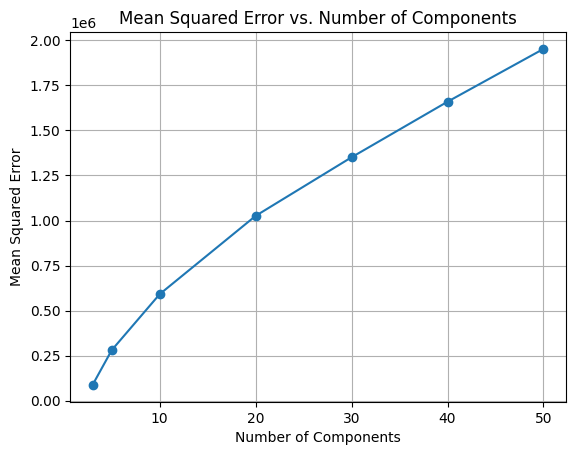

In [29]:
# Plot MSE vs. number of components
plt.plot(components, mse, marker='o')
plt.title('Mean Squared Error vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()


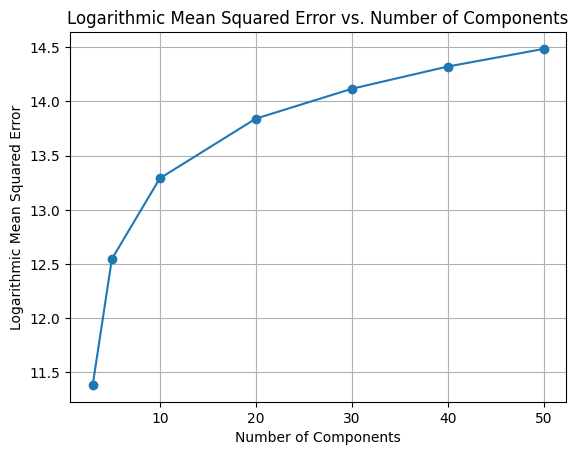

In [30]:
    # Plot Logarithmic MSE vs. number of components
    plt.plot(components, np.log(mse), marker='o', label='Logarithmic Mean Squared Error')
    plt.title('Logarithmic Mean Squared Error vs. Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Logarithmic Mean Squared Error')
    plt.grid(True)
    plt.show()